In [ ]:
#Imports
!pip install kaggle
from zipfile import ZipFile as z
from google.colab import files

In [ ]:
#Kaggle Data Import
files.upload()

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download --force -d tanlikesmath/diabetic-retinopathy-resized

In [ ]:
file_name = "diabetic-retinopathy-resized.zip"

with z(file_name, 'r') as zi:
  zi.extractall()
  print('done')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [8]:
import os
import pandas as pd 
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from glob import glob
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from sklearn.model_selection import train_test_split

In [ ]:
path = "/content/resized_train_cropped/resized_train_cropped"
data = "/content/resized_train_cropped/resized_train_cropped"
print('number of images in total - ',len(os.listdir(data)))

In [ ]:
data = pd.read_csv("/content/trainLabels.csv") 
data.head()

In [ ]:
data['image_name'] = [i+".jpeg" for i in data['image'].values]
data.head()

In [12]:
train, val = train_test_split(data, test_size=0.15)

In [ ]:
train.shape, val.shape

In [14]:
import cv2
def load_ben_color(image):
    IMG_SIZE = 224
    sigmaX=10
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)
    return image

In [15]:
data_gen = ImageDataGenerator(rescale=1/255.,
                              zoom_range=0.15,
                              fill_mode='constant',
                              cval=0.,
                              horizontal_flip=True,
                              vertical_flip=True,
                              preprocessing_function=load_ben_color)

In [ ]:
# batch size
bs = 128

train_gen = data_gen.flow_from_dataframe(train, 
                                        path,
                                         x_col="image_name", y_col="level", class_mode="raw",
                                         batch_size=bs,
                                         target_size=(224, 224))
val_gen = data_gen.flow_from_dataframe(val,
                                       path,
                                       x_col="image_name", y_col="level", class_mode="raw",
                                       batch_size=bs,
                                       target_size=(224, 224))

In [17]:
from keras.applications.resnet50 import ResNet50
import keras.layers as L
from keras.models import Model

In [ ]:
base_model = ResNet50(weights='imagenet',
                   include_top=False,
                   input_shape=(224, 224, 3))

x = base_model.output
x = L.GlobalMaxPooling2D()(x)
x = L.BatchNormalization()(x)
x = L.Dropout(0.2)(x)
x = L.Dense(1024, activation="relu")(x)
x = L.Dropout(0.1)(x)
x = L.Dense(64, activation="relu")(x)
predictions = L.Dense(5, activation='softmax')(x)

In [19]:
model = Model(inputs=base_model.input, outputs=predictions)

In [20]:
for layer in base_model.layers[:-20]: layer.trainable = False

In [41]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

In [43]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [45]:
mmodel_history = model.fit(train_gen, steps_per_epoch=int(29842/128), epochs=2,  validation_data=val_gen, validation_steps=int(5266/128))

Epoch 1/10
233/233 [==============================] - 978s 4s/step - loss: 1.1454 - accuracy: 0.6850 - val_loss: 0.9753 - val_accuracy: 0.7348
Epoch 2/10
233/233 [==============================] - 969s 4s/step - loss: 0.9068 - accuracy: 0.7303 - val_loss: 0.9026 - val_accuracy: 0.7361
Epoch 3/10
233/233 [==============================] - 962s 4s/step - loss: 0.8799 - accuracy: 0.7325 - val_loss: 0.8784 - val_accuracy: 0.7365
Epoch 4/10
233/233 [==============================] - 963s 4s/step - loss: 0.8699 - accuracy: 0.7357 - val_loss: 0.8539 - val_accuracy: 0.7361
Epoch 5/10
233/233 [==============================] - 961s 4s/step - loss: 0.8728 - accuracy: 0.7331 - val_loss: 0.9105 - val_accuracy: 0.7327
Epoch 6/10
233/233 [==============================] - 947s 4s/step - loss: 0.8668 - accuracy: 0.7306 - val_loss: 0.8627 - val_accuracy: 0.7357
Epoch 7/10
233/233 [==============================] - 919s 4s/step - loss: 0.8541 - accuracy: 0.7368 - val_loss: 0.8391 - val_accuracy: 0.7359

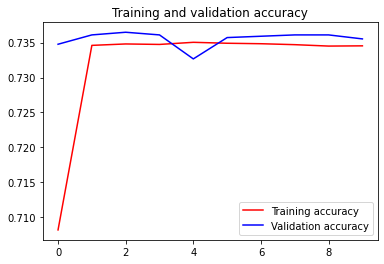

<Figure size 432x288 with 0 Axes>

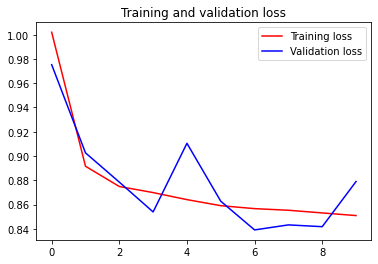

<Figure size 432x288 with 0 Axes>

In [46]:
#SAVING WEIGHTS

model.save('dr_weights.h5')

#MODEL

accNT = mmodel_history.history['accuracy']
val_accNT = mmodel_history.history['val_accuracy']
lossNT = mmodel_history.history['loss']
val_lossNT = mmodel_history.history['val_loss']
epochsNT = range(len(accNT))

plt.plot(epochsNT, accNT, 'r', label='Training accuracy')
plt.plot(epochsNT, val_accNT, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

plt.plot(epochsNT, lossNT, 'r', label='Training loss')
plt.plot(epochsNT, val_lossNT, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

plt.show()